# Домашнее задание 1. Сбор данных

При решении реальных задач мы почти никогда не имеем дело с "хорошими" исходными данными, уже подготовленными для обработки и анализа. Как правило на входе имеются неструкткрированные данные в "грязном" виде, например необработанные тексты, изображения или аудио файлы. Иногда нет даже этого, и данные приходится собирать из разных доступных источников: разнообразных баз данных, внешних сервисов и даже электронных таблиц. После того, как данные получены, их унифицируют, очищают от шума, преобразовывают в нужный вид и сохраняют для дальнейшего анализа. В одном из традиционных подходов к Data Mining этот процесс называется Extract-Transform-Load

In [ ]:
!pip install -r requirements.txt

In [2]:
import vk
import folium
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import time
from folium.plugins import MarkerCluster
%matplotlib inline

Нам потребуется загрузить информацию о местах, в которых совершаются чекины, иначе говоря провести сбор данных (data collection). [Ссылка на ВК для разработчиков](https://vk.com/dev)

Для того, чтобы получить доступ к API прежде всего необходимо зарегистрироваться в VK в качестве разработчика и создать свое [приложение](https://vk.com/apps?act=manage). После создания приложения будет доступен набор ключей, которые мы будем использовать для аутентификации. Далее вам потребуется создать токен авторизации, чтобы получать доступ к API. Этот токен необходимо скопировать в соответствующие константы ниже. Подробнее о том, как работает аутентификация в VK API можно почитать [по ссылке](https://vk.com/dev/first_guide), хотя это нужно скорее для ознакомления: библиотека обращения с API позаботится о механизме аутентификации за нас.

Получение токена: https://oauth.vk.com/authorize?client_id=5898400&display=page&redirect_uri=https://oauth.vk.com/blank.html&scope=friends&response_type=token&v=5.52

In [5]:
ACCESS_TOKEN = '49e1bd6f4ffaa2573752dd61202987f312d6f3872f33ce4fafc0149411f7b651d99faaa684dd7bfcfc090'
session = vk.Session(access_token=ACCESS_TOKEN)
vkapi = vk.API(session=session)

VK API может отдавать вам посещаемые места несколькими способами: в некотором радиусе от точки или же по id самого места. Мы будем пользоваться [вторым способом](https://vk.com/dev/places.getById) . Требуется написать функцию, которая на вход получает объект подключения к API и индекс, до какого объекта требуется запросить. Возвращать она будет pandas.DataFrame с полученными данными.

In [6]:
def get_place_info(vkapi, idx=5000):
    places = range(1, idx+1)
    count = 1000   #VK API не выдает больше 2021 объектов за один запрос, поэтому будем запрашивать по count штук
    all_places = []
    i = 0
    while True:
        #запрашиваем порциями по count, a и b - начало и конец списка идентефикаторов мест
        a = i*count
        b = (i+1)*count if (i+1)*count <= idx else idx
        all_places += vkapi.places.getById(places=places[a:b])
        time.sleep(0.5)
        if b == idx:
            break
        i += 1
    series = pd.DataFrame(all_places)
    return series

Предположим, что мы хотим понять несколько фактов о выборке объектов с id от 1 до 5000.
Помогите нам это сделать.
А вот и сами факты:
1. Провизуализируйте на карте все объекты которые находятся в Москве? Где больше объектов, в центре или на окраине?
2. Посчитайте количество объектов разного типа. Постройте распределение? Объектов какого типа больше в данной выборке?
3. Посчитайте распределение числа чекинов по всей выборке. Визуализируйте его.
4. Постройте box plot по числу чекинов для каждого типа объектов.
5. Преобразуйте поле created в datetime. Как давно были созданы объекты? Сколько объектов существует больше года? 

Не забудьте сохранить данную выборку, в будущем она вам понадобится.

In [7]:
s = get_place_info(vkapi, 5000)
len(s)
#s.to_csv('vk.csv', encoding='utf-8')

5000

In [4]:
#Задание 1
data = pd.read_csv('vk.csv')
mos_center = [55.750475, 37.619020]
mos_min_lat, mos_max_lat = 55.564141, 55.908930
mos_min_lon, mos_max_lon = 37.344362, 37.879945
data_moscow = data[data.latitude.between(mos_min_lat, mos_max_lat) &
                   data.longitude.between(mos_min_lon, mos_max_lon)]
#data_moscow = data[data.city == 1]
print 'In Moscow: ', len(data_moscow)
moscow = folium.Map(location=mos_center, zoom_start=11, control_scale=True)
marker_cluster = MarkerCluster(locations=data_moscow[['latitude', 'longitude']].values)
marker_cluster.add_to(moscow)
moscow

In Moscow:  1671


In [93]:
#приближаем центр эллипсом, полуоси считаем отдельно по широте и долготе
#поскольку градусы широты и долготы немного по-разному переводятся в расстояние

radius_x = 0 #полуось эллипса по X
radius_y = 0 #полуось эллипса по Y
sadovoe_x = [[55.751296, 37.583725], [55.751780, 37.656338]] #левая и правая точка Садового
sadovoe_y = [[55.773557, 37.619945], [55.729603, 37.622349]] #верхняя и нижняя точка Садового
for i in range(2):
    radius_x += abs(sadovoe_x[i][1] - mos_center[1])
    radius_y += abs(sadovoe_y[i][0] - mos_center[0])
    
radius_x /= 2
radius_y /= 2
data_moscow_center = data[(mos_center[0] - data.latitude)**2/radius_y**2 + (mos_center[1] - data.longitude)**2/radius_x**2 <= 1]

print 'all:  {0}\ncenter:  {1}\nnot center:  {2}'.format(len(data_moscow), len(data_moscow_center), len(data_moscow)-len(data_moscow_center))
moscow_cen = folium.Map(location=mos_center, zoom_start=11, control_scale=True)
marker_cluster = MarkerCluster(locations=data_moscow_center[['latitude', 'longitude']].values)
marker_cluster.add_to(moscow_cen)
moscow_cen

all:  1671
center:  480
not center:  1191


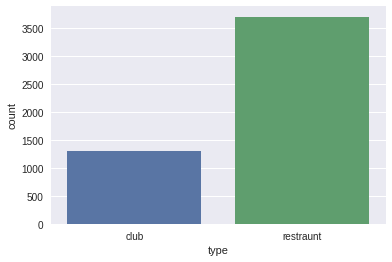

In [3]:
#Задание 2
data = pd.read_csv('vk.csv')
data.type = data.type.replace({3: 'restraunt', 4: 'club'})
sns.countplot(data.type)

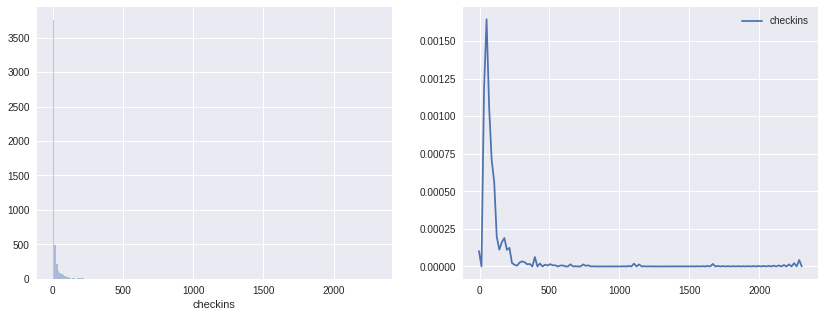

In [19]:
#Задание 3
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
sns.distplot(data.checkins, bins=200, kde=False, ax=axes[0])
sns.kdeplot(data.checkins, ax=axes[1])

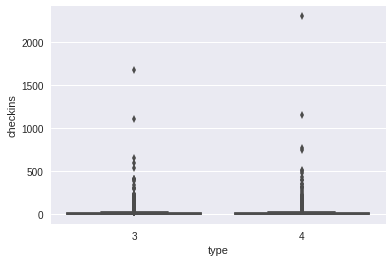

In [12]:
#Задание 4
sns.boxplot(y=data.checkins, x=data.type)

In [91]:
#Задание 5
data = pd.read_csv('vk.csv')
for i in range(len(data)):
    a = data.created[i]
    a = datetime.datetime.fromtimestamp(a)
    data.set_value(i, 'created', a)

year_ago = datetime.datetime.now() - datetime.timedelta(days=365)
data_year_old = data[data.created < year_ago]
print 'Older, then 1 year: {0}'.format(len(data_year_old))
#data

Older, then 1 year: 5000


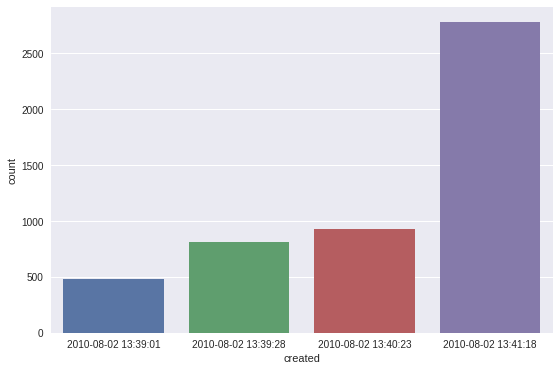

In [54]:
plt.figure(figsize=(9, 6))
sns.countplot(data.created)